# Adaptive Differential Pulse Code Modulation

This code is provided as supplementary material of the lecture Quellencodierung.

This code illustrates
* Combination of adaptive quantization with LMS adaption of predictor
* Very similar to speech codec used in the DECT cordless phone system

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import lfilter
import scipy.signal as sp
import librosa
import librosa.display
import IPython.display as ipd

Load wave file and play original, unquantized version

In [126]:
wave_filename = '../audio/33711__acclivity__excessiveexposure.wav'

# load file, do resample to 8 KhZ (as used in the DPCM system)
x, sampling_rate = librosa.load(wave_filename, sr=8000)

x_max = max(abs(x))

# playback original audio
ipd.Audio(x, rate=sampling_rate)

#### Reminder: Adaptive Quantization with Backward Estimation (AQB)

The AQB algorithm works on recursive computation of new stepsizes $\Delta[k] = M[k]\cdot \Delta[k-1]$
Quantization of $x[k]$ happens according to
$$
	\hat{x}[k] = \mathrm{sign}(x[k])\cdot Z[k]\cdot \frac{\Delta[k]}{2}
$$
with 
$$
Z[k] = 2 \left\lfloor\frac{x[k]}{\Delta[k]}\right\rfloor+1
$$
The new new stepsize $M[k+1]$ is usually obtained as
$$
	M[k+1] = \sqrt{\alpha + (1-\alpha)Z^2[k]\frac{c^2}{4}}
$$
where $\alpha$ and $c$ are parameters that need to be optimized. Here we use the tables from [Jay73] that are optimized for the quantization of predictor coefficients.


[Jay73] N. S. Jayant, "Adaptive Quantization With a One-Word Memory," _Bell System Technical Journal_ , vol. 52, no. 7, pp. 1119--1144, 1973

---

Next, we define the multiplier coefficients and some helping functions

In [121]:
M_dict_DPCM = {2: [0.8, 1.6],
               3: [0.9, 0.9, 1.25, 1.75],
               4: [0.9, 0.9, 0.9, 0.9, 1.2, 1.6, 2.0, 2.4],
               5: [0.9, 0.9, 0.9, 0.9, 0.95, 0.95, 0.95, 0.95, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3.0, 3.3]}


M_dict_PCM = {2: [0.6, 2.2],
              3: [0.85, 1.0, 1.0, 1.5],
              4: [0.8, 0.8, 0.8, 0.8, 1.2, 1.6, 2.0, 2.4],
              5: [0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 0.85, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6]}

# helper function for sign that assigns "+1" to zero
def my_sign(x):
    if np.isscalar(x):
        if np.isclose(x,0):
            return +1.0
        else:
            return np.sign(x)
    else:
        retval = np.sign(x)
        retval[np.isclose(x,np.zeros_like(x))] = +1.0
        return retval

## Experiment A: AQB only, no prediction

We employ $w=4$ bit per sample. Recall that we use a sampling rate of $f_{\mathsf{s}} = 8$ kHz. This amounts a total data rate of $R = w\cdot f_{\mathsf{s}} = 32$ kbit/s. We play the original and the reconstructed signal.

First, we consider the transmitter:

In [122]:
# quantization parameters
w = 4

# select quantizer parameters
Ms = M_dict_PCM[w]
        
# maximum quantizer value
Z_max = 2**(w-1)-1
        
# AQB parameters    
# initial stepsize 0.1, needs to be known at transmitter and receiver
# initial multiplier 1
Delta = 0.05
M = 1


# quantized values, not exactly Z, but just integer representation levels (including sign)
Q = np.zeros_like(x, dtype=int)

for k in range(len(x)):       
    # quantize signal x using AQB
    # compute new stepsize
    Delta = Delta * M            
    
    Q[k] = int(np.floor(np.abs(x[k])/Delta))  

    # saturate quantizer
    if Q[k] < 0:
        Q[k] = 0
    if Q[k] > Z_max:
        Q[k] = Z_max

    # new AQB parameter M
    M = Ms[Q[k]]       
        
    # store quantized value with sign
    Q[k] = (Q[k]+1)*my_sign(x[k])

    

Now, we reconstruct the signal at the receiver:

In [123]:
# recover signal
y = np.zeros_like(x)

# AQB parameters
# initial stepsize 0.1, needs to be known at transmitter and receiver
# initial multiplier 1
Delta = 0.05
M = 1


for k in range(len(y)):
    # undo quantization and update quantizer parameters
    Delta = Delta * M          
    
    Z = np.abs(Q[k]) - 1
    y[k] = (2*Z + 1)*Delta/2 * my_sign(Q[k])        
    
    M = Ms[np.abs(Q[k])-1]    

In [124]:
print('Audio playback of original file')
ipd.display(ipd.Audio(x, rate=sampling_rate))
print('Audio playback of recovered file (after quantization and transmission)')
ipd.display(ipd.Audio(y, rate=sampling_rate))

Audio playback of original file


Audio playback of recovered file (after quantization and transmission)


(-0.35754847526550293, 0.35754847526550293)

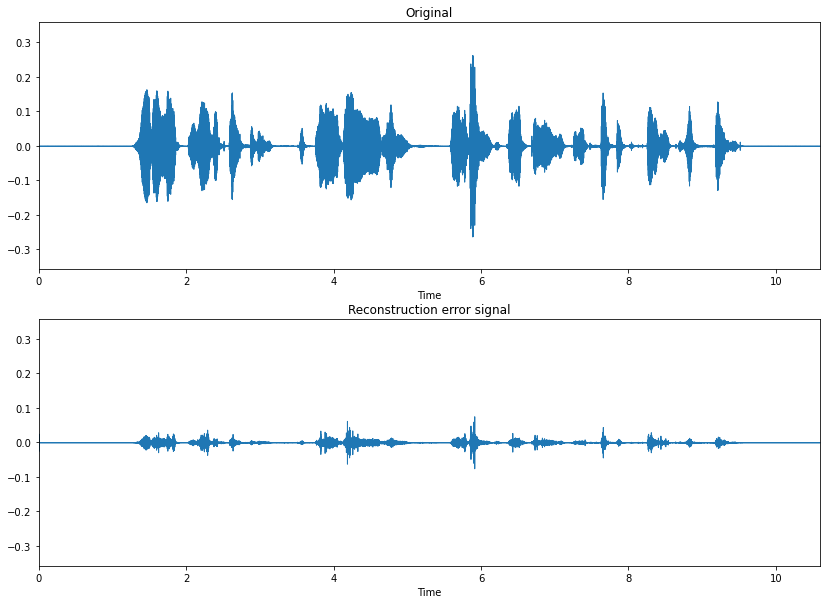

In [127]:
plt.figure(figsize=(14, 10))
plt.subplot(2,1,1)
librosa.display.waveplot(x, sr=sampling_rate)
plt.title('Original')
plt.ylim((-1.2*x_max, +1.2*x_max))
plt.subplot(2,1,2)
librosa.display.waveplot(x-y, sr=sampling_rate)
plt.title('Reconstruction error signal')
plt.ylim((-1.2*x_max, +1.2*x_max))

## Experiment B: AQB and linear prediction with fixed (but optimized prediction coefficients)

Again, we employ $w=4$ bit per sample. Recall that we use a sampling rate of $f_{\mathsf{s}} = 8$ kHz. This amounts a total data rate of $R = w\cdot f_{\mathsf{s}} = 32$ kbit/s. We now additionally use closed-loop prediction (closed-loop DPCM) and quantize the residual signal. We play the original and the reconstructed signal.

First, we calculate the optimal prediction coefficients, where we assume a prediction order of $n=8$

In [148]:
# prediction order
n = 8

# helper function calculating the correlation coefficient as defined in the lecture
def auto_correlation(x, k):
    if k >= 0:
        x_shift = np.roll(x,k)
        x_shift[:k] = 0
    else:
        x_shift = np.roll(x,k)
        x_shift[k:] = 0
        
    return np.correlate(x,x_shift)[0] / len(x)

# signal auto-correlation
phi_XX = np.array([auto_correlation(x,k) for k in np.arange(1,n+1)])

# inefficient way to calculate R_XX as many terms can be reused due to symmetric of the auto-correlation function
R_XX = np.array([[auto_correlation(x,i-j) for j in range(n)] for i in range(n)])

# optimal prediction coefficients
a_fixed = np.linalg.inv(R_XX) @ phi_XX

Now, we implement the transmitter part with closed-loop DPCM

In [140]:
# select quantizer parameters
Ms = M_dict_DPCM[w]
        
       
# initial stepsize 0.1, needs to be known at transmitter and receiver
# initial multiplier 1
Delta = 0.05
M = 1

# memory of the predictor, initialize with zeros, contains the input to the prediction filter, i.e., \tilde{x}
memory = np.zeros(n)


# quantized values, not exactly Z, but just integer representation levels (including sign)
Q = np.zeros_like(x, dtype=int)

for k in range(len(x)):    
    # use python's built-in dot product operator "@" to compute x_hat
    x_hat = a_fixed @ memory
    d = x[k] - x_hat
       
    # quantize residual signal d using AQB
    # compute new stepsize
    Delta = Delta * M            
    
    Q[k] = int(np.floor(np.abs(d)/Delta))  

    # saturate
    if Q[k] < 0:
        Q[k] = 0
    if Q[k] > Z_max:
        Q[k] = Z_max
           
    # new AQB parameter M
    M = Ms[Q[k]]
    
    # change Q for transmission
    Q[k] = (Q[k]+1)*my_sign(d)
    
    Z = np.abs(Q[k]) - 1
    
    # Reconstruct sample for predictor input
    dtilde = (2*Z + 1)*Delta/2 * my_sign(Q[k])    
   
    # update memory of predictor
    memory = np.concatenate(([dtilde+x_hat], memory[:-1]))


Now, the receiver part, reconstruct the signal

In [149]:
# recover signal
y = np.zeros_like(x)


# initial stepsize 0.1, needs to be known at transmitter and receiver
# initial multiplier 1
Delta = 0.05
M = 1

# memory of the receiver predictor, initialize with zeros
memoryr = np.zeros(n)

for k in range(len(y)):
    # undo quantization and update quantizer parameters
    Delta = Delta * M          

    # reconstruct residual error signal
    Z = np.abs(Q[k]) - 1
    dtilde = (2*Z + 1)*Delta/2 * my_sign(Q[k])        
    
    # update AQB multiplier
    M = Ms[np.abs(Q[k])-1]    
    
    xhat = a_fixed @ memoryr
    y[k] = xhat + dtilde
    
    # update memory of predictor
    memoryr = np.concatenate(([y[k]], memoryr[:-1]))

In [150]:
print('Audio playback of original file')
ipd.display(ipd.Audio(x, rate=sampling_rate))
print('Audio playback of recovered file (after quantization and transmission)')
ipd.display(ipd.Audio(y, rate=sampling_rate))

Audio playback of original file


Audio playback of recovered file (after quantization and transmission)


(-0.35754847526550293, 0.35754847526550293)

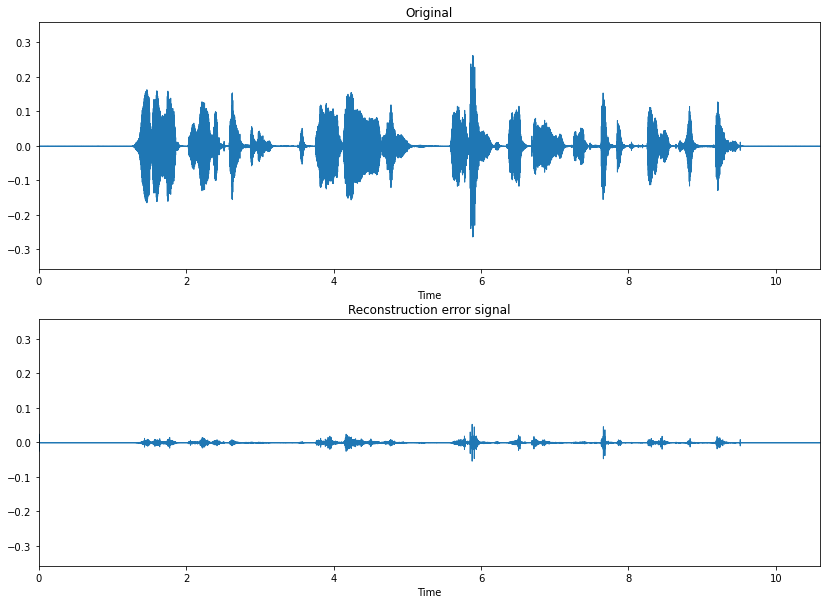

In [151]:
plt.figure(figsize=(14, 10))
plt.subplot(2,1,1)
librosa.display.waveplot(x, sr=sampling_rate)
plt.title('Original')
plt.ylim((-1.2*x_max, +1.2*x_max))
plt.subplot(2,1,2)
librosa.display.waveplot(x-y, sr=sampling_rate)
plt.title('Reconstruction error signal')
plt.ylim((-1.2*x_max, +1.2*x_max))

## Experiment C: AQB and linear prediction with adaptation of predictor coefficients

Again, we employ $w=4$ bit per sample. Recall that we use a sampling rate of $f_{\mathsf{s}} = 8$ kHz. This amounts a total data rate of $R = w\cdot f_{\mathsf{s}} = 32$ kbit/s. We now additionally use closed-loop prediction (closed-loop DPCM) and quantize the residual signal. We play the original and the reconstructed signal.

The prediction coefficients are updated using the LMS algorithm according to
$$
a_i[k+1] = a_i[k] + 2\epsilon \cdot \tilde{d}[k]\cdot \tilde{x}[k-i]
$$
at the transmitter side. At the receiver side, we replace $\tilde{x}[k-i]$ by $y[k-i]$.

In [168]:
# adaptation step size
epsilon = 0.1

Ms = M_dict_DPCM[w]
        
        
# initial stepsize 0.1, needs to be known at transmitter and receiver
# initial multiplier 1
Delta = 0.05
M = 1

# memory of the predictor, initialize with zeros, contains the input to the prediction filter, i.e., \tilde{x}
memory = np.zeros(n)


# initial predictor. Initialize with a_fixed
a = a_fixed.copy()

# save predictor coefficients for later evaluation
a_save = []

# quantized values, not exactly Z, but just integer representation levels (including sign)
Q = np.zeros_like(x, dtype=int)

for k in range(len(x)):
    # use python's built-in dot product operator "@" to compute x_hat
    x_hat = a @ memory
    d = x[k] - x_hat
       
    # quantize residual signal d using AQB
    # compute new stepsize
    Delta = Delta * M            
    
    Q[k] = int(np.floor(np.abs(d)/Delta))  

    # saturate
    if Q[k] < 0:
        Q[k] = 0
    if Q[k] > Z_max:
        Q[k] = Z_max
           
    # new AQB parameter M
    M = Ms[Q[k]]
    
    # transmitted value
    Q[k] = (Q[k]+1)*my_sign(d)
        
    
    # Reconstruct sample for LMS adaptation and feeding into predictor
    Z = np.abs(Q[k]) - 1
    dtilde = (2*Z + 1)*Delta/2 * my_sign(Q[k])    
   
    # determine new predictor coefficients using LMS method
    if k >= n:       
        a = a + 2*epsilon * dtilde * memory
    
    a_save.append(a)
    # update memory of predictor
    memory = np.concatenate(([dtilde+x_hat], memory[:-1]))


Now, we recover the signal

In [169]:
# recover signal
y = np.zeros_like(x)

# receiver predictor coefficients
ar = a_fixed.copy()
#ar[0] = 0.9


# initial stepsize 0.1, needs to be known at transmitter and receiver
# initial multiplier 1
Delta = 0.05
M = 1

# memory of the receiver predictor, initialize with zeros
memoryr = np.zeros(n)

for k in range(len(y)):
    
    # undo quantization and update quantizer parameters
    Delta = Delta * M              
    Z = np.abs(Q[k]) - 1
    dtilde = (2*Z + 1)*Delta/2 * my_sign(Q[k])        
    M = Ms[np.abs(Q[k])-1]    

    # undo prediction
    xhat = ar @ memoryr
    y[k] = xhat + dtilde

    # determine new predictor coefficients
    if k >= n:
        ar = ar + 2*epsilon * dtilde * memoryr
        
    memoryr = np.concatenate(([y[k]], memoryr[:-1]))

In [170]:
print('Audio playback of original file')
ipd.display(ipd.Audio(x, rate=sampling_rate))
print('Audio playback of recovered file (after quantization and transmission)')
ipd.display(ipd.Audio(y, rate=sampling_rate))

Audio playback of original file


Audio playback of recovered file (after quantization and transmission)


(-0.35754847526550293, 0.35754847526550293)

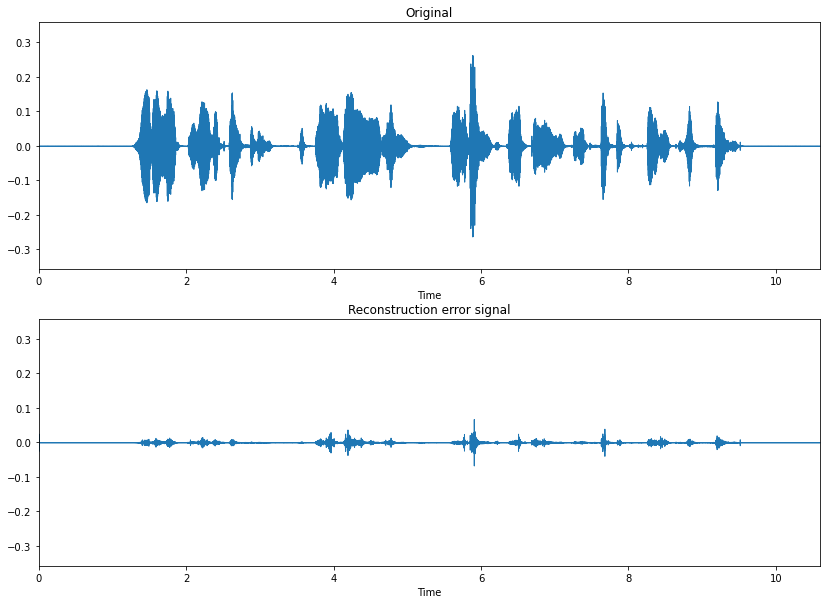

In [171]:
plt.figure(figsize=(14, 10))
plt.subplot(2,1,1)
librosa.display.waveplot(x, sr=sampling_rate)
plt.title('Original')
plt.ylim((-1.2*x_max, +1.2*x_max))
plt.subplot(2,1,2)
librosa.display.waveplot(x-y, sr=sampling_rate)
plt.title('Reconstruction error signal')
plt.ylim((-1.2*x_max, +1.2*x_max))

The main issue with adaptive quantization is that the synthesis filter can potentially become unstable. Recall that the transfer function of the synthesis filter is
$$
H(z) = \frac{1}{1-A(z)} = \frac{1}{1 - a_1z^{-1} - a_2z^{-2} - \ldots - a_nz^{-n}}
$$
The synthesis filter is only stable if all its poles are inside the unit circle. Next, we plot the evolution of the poles over the time. We can see that the poles are all within the unit circle.

Text(0, 0.5, '$\\Im\\{p\\}$')

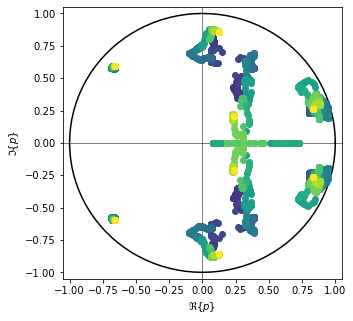

In [197]:
fig,ax = plt.subplots(1,1,figsize=(5,5))        



#plot unit circle
t = np.linspace(0,2*np.pi,101)
plt.plot(np.cos(t), np.sin(t), 'k-')
plt.plot([0,0],[-1.5,1.5],'k',linewidth=0.5)
plt.plot([-1.5,1.5],[0,0],'k',linewidth=0.5)

pole_range = range(0,len(a_save),100)

colors = plt.cm.viridis(np.linspace(0,1,len(pole_range)))

for c,k in enumerate(pole_range):            
    # get poles
    _,p,_ = sp.tf2zpk(1, np.concatenate(([1],-a_save[k])))
    #draw horizontal and vertical axes
    plt.plot(p.real, p.imag, 'o',color=colors[c])                        
    
plt.ylim((-1.05,1.05))
plt.xlim((-1.05,1.05))
plt.xlabel(r'$\Re\{p\}$')
plt.ylabel(r'$\Im\{p\}$')